# Donkey Car Functional CNN (Exporatory Experiment)

## An Explorational Notebook where several Keras Functional API Models are tested, compared, and eventually merged together in an effort to get to a final design

The set of Models found in this notebook will be exploring several concepts - such as custom layers, multi-input multi-output models, and several other tweaks and tricks as found in the Keras Developer Guide (https://keras.io/guides/)

This will also serve as a sort of comparison platform for these models, and these concepts may or may not be carried over to the final design workflow.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Step 1: Dataset Retrieval and Management
The Dataset used for this experiment is found in the mounted Google Drive folder (if not mounted, contact me and we can try sort it out). The dataset consists of images, and json labels for those images. The json labels contain the driving angle as floating point values in the range of -1 and 1. -1 means all the way left, and 1 means all the way to the right. We are not addressing throttle labels in this experiment. 


In [ ]:
#Mount Data Folder From Google Drive:

#path = "/content/drive/My Drive/DIYRobocars_2020/Data/halldatarecords2/"
path = "./Documents/DonkeyCar/SimDataGenTrack1/"
#path = "./Documents/DonkeyCar/SimDataWHCounterClockwise/"

In [ ]:
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/SimDataGenTrack1.zip'
#!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/SimDataWHClockwise.zip'
#!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/SimDataWHCounterClockwise.zip'

In [ ]:
#Import required packages for this step:

import os   #For retrieving files
import natsort #For sorting retrieved files
import numpy as np #Calculations, arrays, etc.
import cv2 #Image preprocessing, loading and saving images
import json #For processing json files
import tensorflow as tf  #For the ML side
from random import randrange 

import matplotlib.pyplot as plt #Plots


#Make sure plots happen inline


%matplotlib inline

In [ ]:
#Read data from files into corresponding lists
#You may need to run this cell several times - colabs connection to Drive times 
#out if the number of files to retrieve get too large. If this is the case, run
#it a few times until it works. Colab caches files already retrieved in the last run,
#so rerunning it several times will eventually get all the files read. Clumsy, but
#don't shoot the messenger. Their docs themselves say this.
%%time

im_list = [] #initialise list of images

rec_list = [] #initialise list of records

#Read relevant files into relevant lists

for file in os.listdir(path):
    if 'cam' in file:
        im_list.append(file)
    elif 'record' in file:
        rec_list.append(file)

print(len(im_list))
print(len(rec_list))

15061
15061
CPU times: user 18.1 ms, sys: 12.2 ms, total: 30.3 ms
Wall time: 32.3 ms


(15061, 120, 160, 3)
(15061,)
0.0


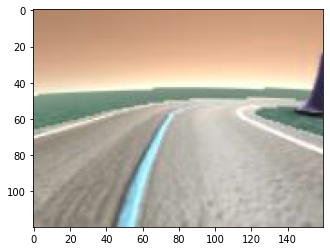

CPU times: user 16.9 s, sys: 6.38 s, total: 23.3 s
Wall time: 33.6 s


In [ ]:
%%time

#Import Image from Pillow
from PIL import Image
#THIS TAKES ABSOLUTELY FOREVER TO RUN I AM SORRY - maybe try to copy paste zip file from drive to colab and work from there?
#Sort data lists and split into data and labels

im_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #Sort by filename number
rec_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #sort by filename number

#Create Images array:

width = 120 #set image width
height = 160 #set image height
color = 3  #set colour channels
dim = (width, height) #Create dimension tuple

#Initialise images array:

x_images = np.zeros((len(rec_list), width, height, color), dtype = np.float32)

print(x_images.shape)
#Read images into images array
for i in range(len(im_list)):
    filename = im_list[i]
    image = cv2.imread(path+filename)
    x_images[i,:,:,:] = tf.cast(image, tf.float32) #cast to a float value compatible with Tensorflow Tensors

#read angle labels into y_labels array
json_data = {}
y_labels = np.zeros(len(rec_list), dtype=np.float32) #setup label array 
print(y_labels.shape)
for i in range(len(rec_list)):
    filename = rec_list[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        y_labels[i] = orient

randomImage = randrange(len(x_images)) #Get an index for a random image to show to ensure data read correctly
print(y_labels[randomImage])
plt.imshow(x_images[randomImage].astype('uint8'))
plt.show() #Show Image

0.19998672066927828


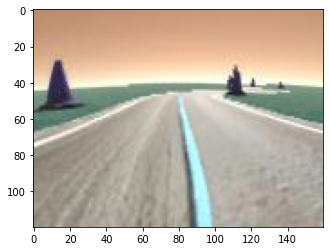

0.0


In [ ]:
#Donkey Training and Val data splits

def train_test_split(data_list,label_list, shuffle=True, test_size=0.2):
    '''
    take a list, split it into two sets while selecting a 
    random element in order to shuffle the results.
    use the test_size to choose the split percent.
    shuffle is always True, left there to be backwards compatible
    '''
    assert shuffle
    data_list = list(data_list)
    label_list = list(label_list)
    train_data = []
    train_labels =[]

    target_train_size = len(data_list) * (1. - test_size)

    i_sample = 0

    while i_sample < target_train_size and len(data_list) > 1:
        i_choice = np.random.randint(0, len(data_list) - 1)
        train_data.append(data_list.pop(i_choice))
        train_labels.append(label_list.pop(i_choice))
        i_sample += 1

    # remainder of the original list is the validation set
    val_data = data_list
    val_labels = label_list
    return val_data, train_data, val_labels, train_labels

x_val, x_train, y_val, y_train = train_test_split(x_images,y_labels)

print(len(x_val)/len(x_images))

plt.imshow(x_train[1000].astype('uint8'))
plt.show()
print(y_train[1000])
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

### Step 2: Set ALL THE POSSIBILITIES

Neptune Experiment Setup Begins Here https://ui.neptune.ai/charag/Littlefoot/experiments?viewId=standard-view. These experiments run here need to be tagged with the name of the architecture, and are named FuncExplore_[NetworkType]. Tags and parameters as relevant to your experiment may also be set. Remember to include what you are doing and why in the description of the experiment.


Each different network type has its own build cell, fit cell, and validation cell. They also get their own subheading and description. Experiments are started and ended in each network's fit cell.

In [ ]:
import os
os.environ['NEPTUNE_API_TOKEN'] = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOTgyNzBkM2EtMzZhNC00NDkwLWJiNmEtNDJiYzQ0ZDRjZWNkIn0='

In [ ]:

#Neptune experiment initialization:
try:
   import neptune
except:
  !pip install neptune-client
  import neptune
#Import neptune and initialise tracking of an experiment

neptune.init(
    api_token=None,
    project_qualified_name="charag/Littlefoot"
) #API Token is set to environment variable and the project name littlefoot is selected


#Enable logging in a neptune experiment - define keras callbacks and create a neptune logger class

from tensorflow.keras.callbacks import Callback

class NeptuneLogger(Callback):

    def on_batch_end(self, batch, logs={}): #Log metrics after every batch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'batch_{log_name}', log_value)

    def on_epoch_end(self, epoch, logs={}): #log metrics after every epoch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'epoch_{log_name}', log_value)



In [ ]:
# Imports: Tensorflow 1.14.0 is used
import os
import numpy as np

from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, Convolution1D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda


###2.1 - Base CNN With Functional API

Redoing the Base CNN with Keras' functional API - including graph plot function

####2.1.1 Model Architecture and Compile

In [ ]:
#Model Structure Setup:

model = Sequential()

model.add(Convolution2D(12, (3,3), strides=(2,2), activation='relu', input_shape=(120,160,3)))
model.add(Convolution2D(24, (3,3), strides=(2,2), activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(32, (3,3), strides=(2,2), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(3,1,padding='valid'))
model.add(Convolution2D(64, (3,3), strides=(2,2), activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(64, (3,3), strides=(1,1), activation='relu'))
#model.add(Dropout(0.1))
model.add(Convolution2D(128, (3,3), strides=(2,2), activation='relu'))

model.add(Flatten())
#model.add(Reshape((1,768))
#model.add(Conv1D(32, 3, strides=1,activation='relu'))

model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(250, activation='relu'))
model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear')) #Regression Output


#Compile Model 
LOSS = 'mse'
OPTIMIZER = 'adam'
model.compile(optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=['accuracy'])

model.summary()

#Plot Graph

#### 2.1.2 Experiment Setup and Fit Model

In [ ]:
#Experiment Parameters:

OPTIMIZER = OPTIMIZER #stochastic gradient descent
LOSS = LOSS #absolute error from the value desired
EPOCH = 300
BATCH = 132
KERNEL1 = 5
KERNEL2 = 3
STRIDE = 2
CONVLAYERS = 6
DENSELAYERS = 4
POOLLAYERS = 1
PRUNING = "dropout"

#Start Experiment:
neptune.create_experiment(name='Base CNN Build',
                          params={'epochs': EPOCH,
                                  'batch_size': BATCH,
                                  'Convolutional Layers': CONVLAYERS,
                                  'Dense Layers': DENSELAYERS,
                                  'Pooling Layers': POOLLAYERS,
                                  'Optimization' : OPTIMIZER,
                                  'LOSS': LOSS},         
                          tags=['Base_CNN_Build', 'Dropout'],
                          )


#Fit Model to Data
EarlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
save_best = keras.callbacks.ModelCheckpoint('Lit.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#model.fit(x_fit, y_fit, epochs=EPOCH, batch_size=1, validation_data=(x_fit, y_fit),callbacks=[NeptuneLogger()], shuffle=True, verbose=1)

#model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH, validation_data=(x_val, y_val),callbacks=[NeptuneLogger(), EarlyStop, save_best], shuffle=True, verbose=1)

model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH, validation_data=(x_val, y_val),callbacks=[NeptuneLogger(), save_best], shuffle=True, verbose=1)
#Stop Neptune Experiment:

neptune.stop()

In [ ]:
#Validate Model

num = randrange(len(x_val))

#Select Random Image and Label to show as examples
plt.imshow(x_val[num].astype('uint8'))
plt.show()

pred_im = x_val[num]
pred_label = y_val[num]

print("Label:")
print(pred_label)

#Model prediction
diff = np.zeros(len(y_val))
perc = np.zeros(len(y_val))

ModelBest = keras.models.load_model('Lit.h5')

#label_out = model.predict(x_val, batch_size=BATCH,verbose=1)
label_out = ModelBest.predict(x_val, batch_size=BATCH,verbose=1)
ModelBest.evaluate(x_val, y_val, batch_size=BATCH, verbose=1)

for i in range(0, len(y_val)):
  diff[i] = abs(y_val[i] - label_out[i])
  perc[i] = (np.max(y_val)-diff[i])/np.max(y_val)
model.save('LIT-16.h5')
print("result:")
print(label_out[num])
print(np.sum(diff)/len(diff))
print(np.sum(perc)/len(perc))
print(1-np.sum(perc)/len(perc))

**bold text**####2.1.1 Model Architecture and Compile

In [ ]:
#Model Structure Setup:

model = Sequential()

model.add(Convolution2D(12, (3,3), strides=(2,2), activation='relu', input_shape=(120,160,3)))
model.add(Convolution2D(24, (3,3), strides=(2,2), activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(32, (3,3), strides=(2,2), activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(3,1,padding='valid'))
model.add(Convolution2D(64, (3,3), strides=(2,2), activation='relu'))
model.add(Dropout(0.1))
model.add(Convolution2D(64, (3,3), strides=(1,1), activation='relu'))
#model.add(Dropout(0.1))
model.add(Convolution2D(128, (3,3), strides=(2,2), activation='relu'))

model.add(Flatten())
#model.add(Reshape((1,768))
#model.add(Conv1D(32, 3, strides=1,activation='relu'))

model.add(Dense(1000, activation='relu'))
model.add(Dense(500, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(250, activation='relu'))
model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear')) #Regression Output


#Compile Model 
LOSS = 'mse'
OPTIMIZER = 'adam'
model.compile(optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=['accuracy'])

model.summary()

#Plot Graph

###2.2 Donkey Car Standard Regression Model (Functional API)

####2.1.1 Model Architecture and Compile

In [ ]:
#Donkeycar Standard Regression Model
model = Sequential()
model.add(Input(shape=(120,160,3), name='img_in'))
model.add(Convolution2D(24, (5,5), strides=(2,2), activation='relu', name="conv2d_1"))
model.add(Dropout(drop))
model.add(Convolution2D(32, (5,5), strides=(2,2), activation='relu', name="conv2d_2"))
model.add(Dropout(drop))
model.add(Convolution2D(64, (5,5), strides=(2,2), activation='relu', name="conv2d_3"))
model.add(Dropout(drop))
model.add(Convolution2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_4"))
model.add(Dropout(drop))
model.add(Convolution2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_5"))
model.add(Dropout(drop))
    
model.add(Flatten(name='flattened'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(drop))
model.add(Dense(50, activation='relu'))
model.add(Dropout(drop))
model.add(Dense(1,activation='linear'))


#Compile Model 
LOSS = 'mse'
OPTIMIZER = 'adam'
model.compile(optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=['accuracy'])

model.summary()

#Plot Graph